# Lineare Regression mit realen Daten

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

## Schritt 1: Daten sammeln (hier einlesen)

In [2]:
data=pd.read_csv("car_data.csv")

In [3]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
data.shape

(4340, 8)

## Schritt 2: Daten aufbereiten

In [5]:
data.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

In [6]:
data.drop(['name'],axis=1,inplace=True)

In [7]:
data.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [8]:
data.shape

(4340, 7)

In [9]:
np.sort(data["year"].unique())

array([1992, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

<AxesSubplot:xlabel='year', ylabel='count'>

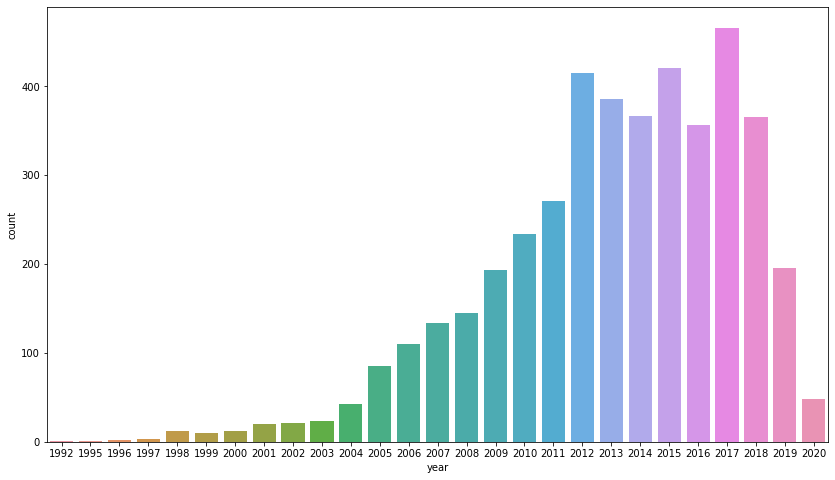

In [10]:
plt.figure(figsize=(14,8))
sns.countplot(x=data['year'])

In [11]:
print("Fuel unique: ", data["fuel"].unique())
print("Seller unique: ", data["seller_type"].unique())
print("Transmission: ", data["transmission"].unique())
print("Owner: ", data["owner"].unique())

Fuel unique:  ['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric']
Seller unique:  ['Individual' 'Dealer' 'Trustmark Dealer']
Transmission:  ['Manual' 'Automatic']
Owner:  ['First Owner' 'Second Owner' 'Fourth & Above Owner' 'Third Owner'
 'Test Drive Car']


<AxesSubplot:xlabel='fuel', ylabel='selling_price'>

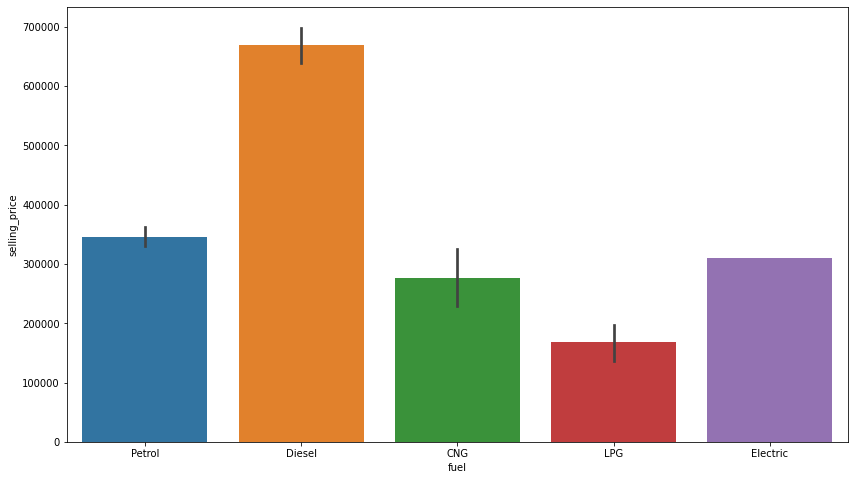

In [12]:
plt.figure(figsize=(14,8))
sns.barplot(x=data['fuel'], y=data['selling_price'])

In [13]:
data.loc[data['fuel'] == 'Electric']

,year,selling_price,km_driven,fuel,seller_type,transmission,owner
4145,2006,310000,62000,Electric,Dealer,Automatic,Second Owner


<AxesSubplot:xlabel='fuel', ylabel='count'>

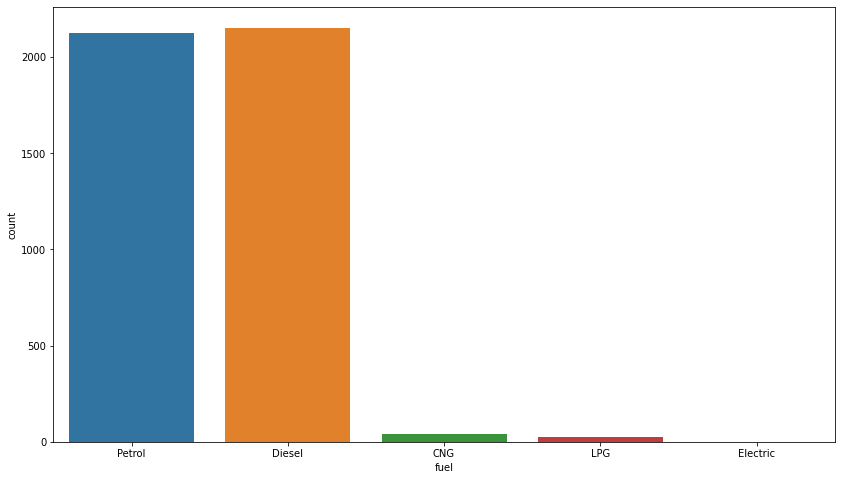

In [14]:
plt.figure(figsize=(14,8))
sns.countplot(x=data['fuel'])

In [15]:
# fuel
data['fuel'] = data['fuel'].map({
    'LPG':1,
    'CNG':2,
    'Electric': 3,
    'Petrol': 4,
    'Diesel': 5
})

# seller_type
data['seller_type'] = data['seller_type'].map({
    'Individual': 1,
    'Dealer': 2,
    'Trustmark Dealer': 3
})

# transmission
data['transmission'] = data['transmission'].map({
    'Manual': 1,
    'Automatic': 2
})

# owner
data['owner'] = data['owner'].map({
    'Test Drive Car': 1,
    'First Owner': 2,
    'Second Owner': 3,
    'Third Owner': 4,
    'Fourth & Above Owner': 5
})

In [16]:
data.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,2007,60000,70000,4,1,1,2
1,2007,135000,50000,4,1,1,2
2,2012,600000,100000,5,1,1,2
3,2017,250000,46000,4,1,1,2
4,2014,450000,141000,5,1,1,3


In [17]:
min_max = MinMaxScaler()
data_scaled=pd.DataFrame(min_max.fit_transform(data), columns=data.columns)

data_scaled.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,0.535714,0.004505,0.086783,0.75,0.0,0.0,0.25
1,0.535714,0.012950,0.061988,0.75,0.0,0.0,0.25
2,0.714286,0.065315,0.123976,1.00,0.0,0.0,0.25
3,0.892857,0.025901,0.057028,0.75,0.0,0.0,0.25
4,0.785714,0.048423,0.174807,1.00,0.0,0.0,0.50


In [18]:
data_scaled = data_scaled.reindex(columns=['selling_price','year','km_driven','fuel','seller_type','transmission','owner'])
data_scaled.head()

,selling_price,year,km_driven,fuel,seller_type,transmission,owner
0,0.004505,0.535714,0.086783,0.75,0.0,0.0,0.25
1,0.012950,0.535714,0.061988,0.75,0.0,0.0,0.25
2,0.065315,0.714286,0.123976,1.00,0.0,0.0,0.25
3,0.025901,0.892857,0.057028,0.75,0.0,0.0,0.25
4,0.048423,0.785714,0.174807,1.00,0.0,0.0,0.50


In [19]:
# Aufteilung in Traings- und Testdaten (80:20)
training_data = data_scaled.sample(frac=0.8,random_state=1)
test_data = data_scaled.drop(training_data.index)

## Schritt 3: Model trainieren

In [20]:
kf = KFold(n_splits=10)

lin_reg_models = []
val_indexes = []
for train_index, val_index in kf.split(training_data):
    model = LinearRegression().fit(training_data.iloc[train_index, 1:], training_data.iloc[train_index, 0])

    lin_reg_models.append(model)
    val_indexes.append(val_index)

## Schritt 4: Model auswerten

In [21]:
i=0
for model, val_index in zip(lin_reg_models, val_indexes):
    print("Datensatz", i, "Score:", model.score(training_data.iloc[val_index, 1:], training_data.iloc[val_index, 0]))
    i=i+1
    

Datensatz 0 Score: 0.5074757071253542
Datensatz 1 Score: 0.5132381942032378
Datensatz 2 Score: 0.4283218313247753
Datensatz 3 Score: 0.3831328643560551
Datensatz 4 Score: 0.4974559883088048
Datensatz 5 Score: 0.4176233240477475
Datensatz 6 Score: 0.361968897597185
Datensatz 7 Score: 0.42933534288857544
Datensatz 8 Score: 0.39178360109292454
Datensatz 9 Score: 0.4082324346269862


## Schritt 5: Parametertuning

Wird in diesem Beispiel übersprungen.

## Schritt 6: Testdaten

In [22]:
final_model = LinearRegression().fit(training_data.iloc[:, 1:], training_data.iloc[:, 0])

print("Score:", final_model.score(test_data.iloc[:, 1:], test_data.iloc[:, 0]))

Score: 0.5011944988645847
